__MERCEDES STOCK PRICE PREDICTION__

*Building a Price Series ARIMA Model for Mercedes Stock Price Prediction*



__1. Dataframe Preparation__

In [302]:
#Importing Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [303]:
#Read in my csv file
df = pd.read_csv('mercedes.csv')

In [304]:
df.head(100)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,41.092484,41.845215,40.971882,41.566578,33.846729,2973654
1,2020-01-03,41.296261,41.362801,40.302322,40.813847,33.233799,4014262
2,2020-01-06,40.202515,40.593433,39.703465,40.593433,33.054317,3441396
3,2020-01-07,40.797215,41.208927,40.680767,40.917816,33.318455,2816618
4,2020-01-08,40.589275,41.167339,40.489468,41.146545,33.504704,2659070
...,...,...,...,...,...,...,...
95,2020-05-19,26.283218,26.511950,25.081345,25.788330,20.998856,8388974
96,2020-05-20,25.804964,26.807220,25.018963,26.624235,21.679514,7726392
97,2020-05-21,26.316488,26.832172,25.975473,26.154299,21.296856,5300838
98,2020-05-22,25.476423,26.844648,25.322552,26.066965,21.225742,6863960


In [305]:
# Dropping unnecessary columns as this is a univariant time series
df = df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])

In [306]:
df.head()

,Date,Close
0,2020-01-02,41.566578
1,2020-01-03,40.813847
2,2020-01-06,40.593433
3,2020-01-07,40.917816
4,2020-01-08,41.146545


In [307]:
df.describe()

,Close
count,1105.000000
mean,57.592108
std,14.356889
min,18.165363
25%,50.619999
50%,62.031727
75%,67.978722
max,76.610001


__2. Stationarity__

*ADF test to check if series is stationary - p value must be < 0.05 to be classed as stationary*

In [342]:
#Check if my series is stationary or not
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.Close.dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.3781082170041912
p-value: 0.5927251601948892


p value = 0.59

p value > 0.05 therefore time series is NOT stationary

In [313]:
#Installing ARIMA
!pip install pmdarima

__3. Finding Parameters__

*Finding d, p and q terms*

In [317]:
from pmdarima.arima.utils import ndiffs

In [343]:
#Calculating ACF Differencing (d) term
ndiffs(df.Close, test='adf')

1

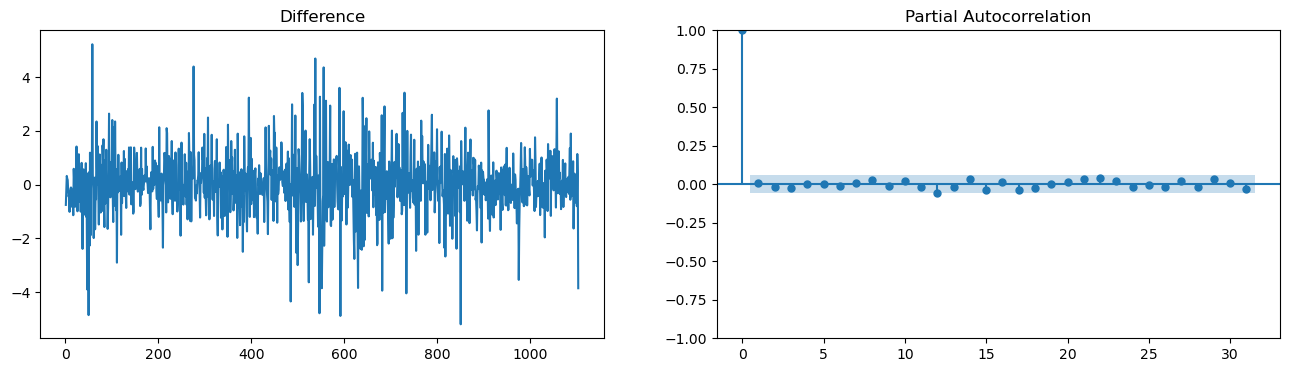

In [319]:
#Calculate p term using pacf plot to calculate number of lags

from statsmodels.graphics.tsaplots import plot_pacf

diff = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('Difference')
ax2.set_ylim(0,1)
plot_pacf(diff, ax=ax2);
#Choosing PCAF lag (p term) = 0 as no points really surpass the significance line

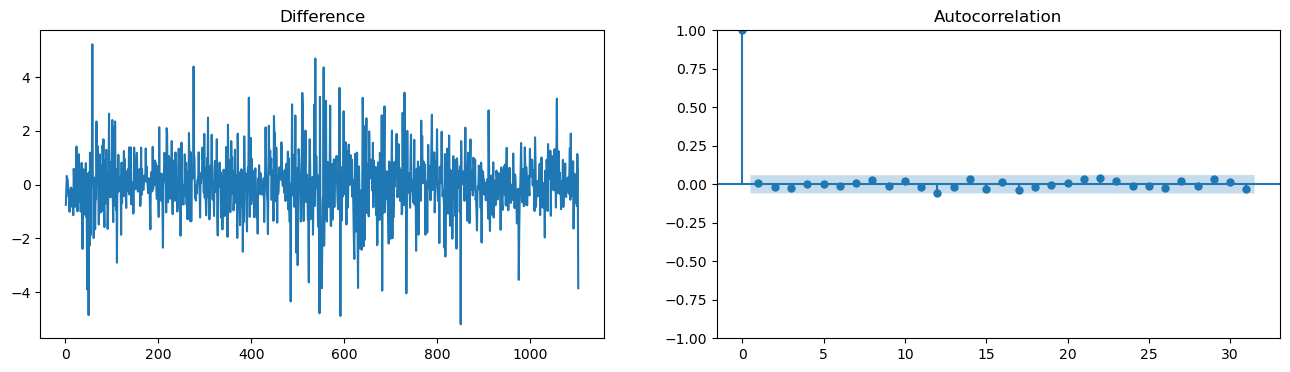

In [320]:
#Finding q term - number of lagged forecast errors
#Find number where spike outside residual line

from statsmodels.graphics.tsaplots import plot_pacf

diff = df.Close.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title('Difference')
ax2.set_ylim(0,1)
plot_acf(diff, ax=ax2);
#Choosing MA (q term) = 12

We now have all our terms to start fitting the model:

p = 0,
d = 1,
q = 12

__4. Fitting the ARIMA Model__

In [321]:
from statsmodels.tsa.arima.model import ARIMA

#ARIMA Model
model = ARIMA(df.Close, order=(0,1,12))
result = model.fit()

In [322]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1105
Model:                ARIMA(0, 1, 12)   Log Likelihood               -1695.502
Date:                Sun, 28 Jul 2024   AIC                           3417.005
Time:                        17:29:13   BIC                           3482.092
Sample:                             0   HQIC                          3441.623
                               - 1105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0079      0.029      0.272      0.785      -0.049       0.065
ma.L2         -0.0120      0.025     -0.474      0.636      -0.062       0.038
ma.L3         -0.0274      0.027     -1.017      0.3

In [323]:
print(f"Length of Actual Values: {len(df['Close'])}")
print(f"Length of Fitted Values: {len(fitted_values)}")


Length of Actual Values: 1105
Length of Fitted Values: 1105


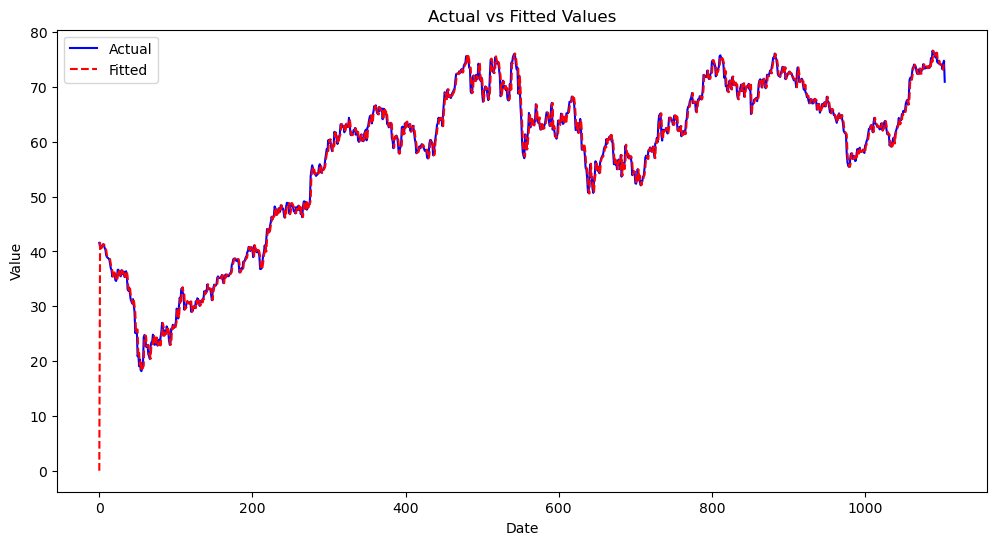

In [324]:
#Plotting Actual vs Fitted

import matplotlib.pyplot as plt
fitted_values = result.fittedvalues
# Plotting Actual vs. Fitted Values
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(df.index, df['Close'], label='Actual', color='blue')

# Plot fitted values
plt.plot(df.index[0:], fitted_values, label='Fitted', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Fitted Values')
plt.legend()
plt.show()

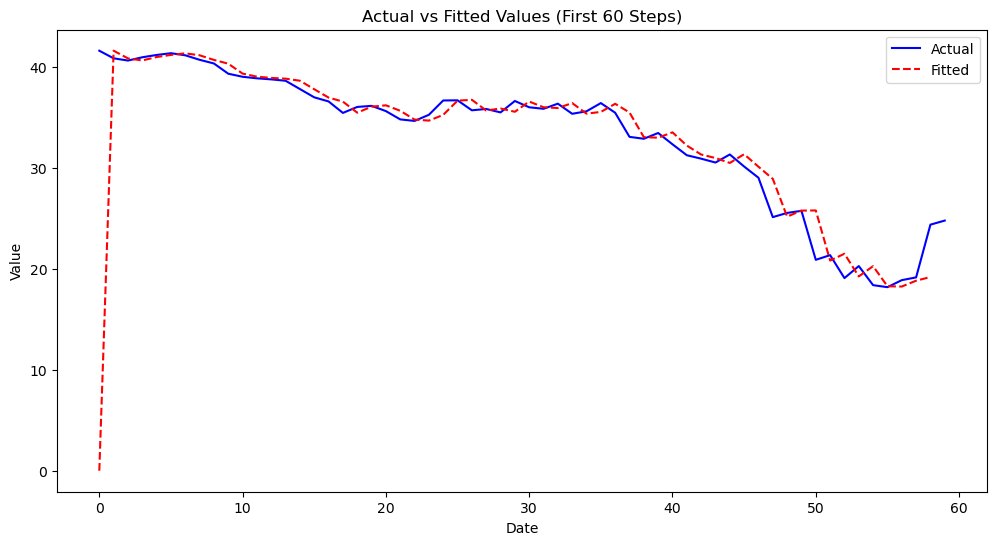

In [325]:
#Plotting first 60 values of Actual vs Fitted

import matplotlib.pyplot as plt

# Generate fitted values
fitted_values = result.fittedvalues

# Align index for fitted values (skipping first element due to differencing)
fitted_values.index = df.index[0:]

# Plotting Actual vs. Fitted Values for the first 60 steps
plt.figure(figsize=(12, 6))

# Plot actual values (first 60 steps)
plt.plot(df.index[:60], df['Close'][:60], label='Actual', color='blue')

# Plot fitted values (first 60 steps)
plt.plot(fitted_values.index[:59], fitted_values[:59], label='Fitted', color='red', linestyle='--')  # Adjust for differencing

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Fitted Values (First 60 Steps)')
plt.legend()
plt.show()

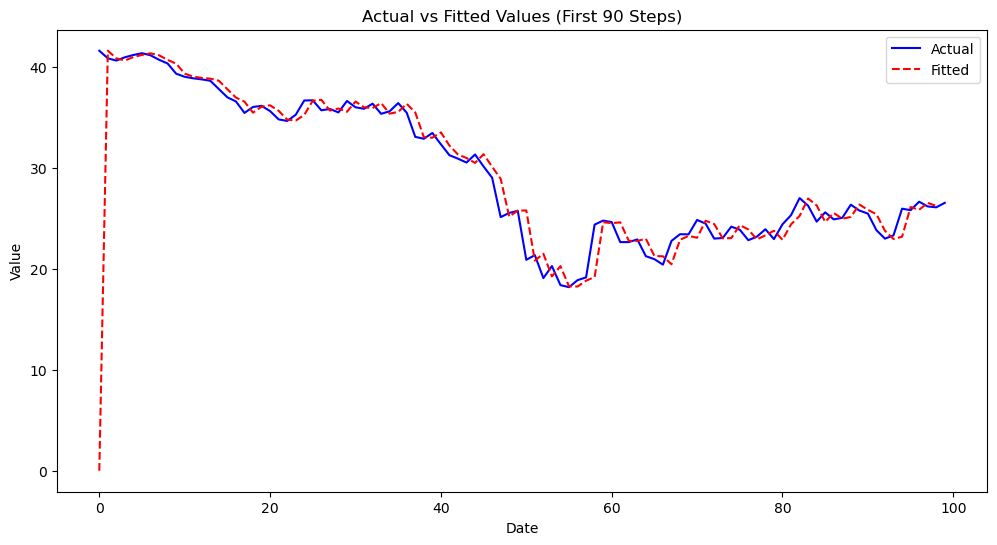

In [326]:
#Plotting first 90 values of Actual vs Fitted

import matplotlib.pyplot as plt

# Generate fitted values
fitted_values = result.fittedvalues

# Align index for fitted values (skipping first element due to differencing)
fitted_values.index = df.index[0:]

# Plotting Actual vs. Fitted Values for the first 60 steps
plt.figure(figsize=(12, 6))

# Plot actual values (first 60 steps)
plt.plot(df.index[:100], df['Close'][:100], label='Actual', color='blue')

# Plot fitted values (first 60 steps)
plt.plot(fitted_values.index[:99], fitted_values[:99], label='Fitted', color='red', linestyle='--')  # Adjust for differencing

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Fitted Values (First 90 Steps)')
plt.legend()
plt.show()


__5.Train Test Split__

In [328]:
#Splitting dataset into a train and test set 
n = int(len(df) * 0.8)
train = df.Close[:n]
test = df.Close[n:]

In [329]:
#Train set contains 80% data, test contans 20%
print(len(train))
print(len(test))

884
221


In [330]:
from statsmodels.tsa.arima.model import ARIMA

In [331]:
#Fitting the model to the train set
model = ARIMA(train, order=(0,1,12))
result = model.fit()

In [332]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  884
Model:                ARIMA(0, 1, 12)   Log Likelihood               -1401.934
Date:                Sun, 28 Jul 2024   AIC                           2829.867
Time:                        17:38:16   BIC                           2892.051
Sample:                             0   HQIC                          2853.644
                                - 884                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0021      0.033      0.064      0.949      -0.063       0.067
ma.L2         -0.0079      0.029     -0.274      0.784      -0.064       0.048
ma.L3         -0.0354      0.030     -1.167      0.243      -0.095       0.024
ma.L4         -0.0087      0.031     -0.278      0.781      -0.070       0.053
ma.L5         -0.0032      0.031     -0.101      0.919      -0.064       0.058
ma.L6         -0.0140      0.033     -0.427      0.669      -0.078       0.050
ma.L7          0.0113      0.035      0.324      0.746      -0.057       0.080
ma.L8          0.0347      0.030      1.161      0.245      -0.024       0.093
ma.L9         -0.0097      0.027     -0.360      0.719      -0.062       0.043
ma.L10         0.0187      0.029      0.640      0.522      -0.039       0.076
ma.L11        -0.0172      0.032     -0.534      0.593      -0.080       0.046
ma.L12        -0.0663      0.032     -2.055      0.040      -0.129      -0.003
sigma2         1.4013      0.045     30.841      0.000       1.312       1.490
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               301.98
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.48   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AR and MA terms good to use, as coef values <> 0

P values also look good

In [333]:
# Forecast the next 'step' values
step = 30
forecast_results = result.get_forecast(steps=step)

# Get the forecasted values
fc = forecast_results.predicted_mean

# Get the confidence intervals
conf = forecast_results.conf_int()

# Get the standard errors
se = forecast_results.se_mean

# Print the forecast, standard error, and confidence intervals
print("Forecasted values:\n", fc)
print("Standard errors:\n", se)
print("Confidence intervals:\n", conf)


Forecasted values:
 884    75.402439
885    75.365332
886    75.416354
887    75.396957
888    75.403385
889    75.432874
890    75.386045
891    75.289155
892    75.251503
893    75.237388
894    75.188937
895    75.220075
896    75.220075
897    75.220075
898    75.220075
899    75.220075
900    75.220075
901    75.220075
902    75.220075
903    75.220075
904    75.220075
905    75.220075
906    75.220075
907    75.220075
908    75.220075
909    75.220075
910    75.220075
911    75.220075
912    75.220075
913    75.220075
Name: predicted_mean, dtype: float64
Standard errors:
 884    1.183784
885    1.675903
886    2.047916
887    2.341431
888    2.597566
889    2.829130
890    3.037078
891    3.236264
892    3.437498
893    3.623947
894    3.808009
895    3.977649
896    4.119257
897    4.256156
898    4.388787
899    4.517525
900    4.642696
901    4.764579
902    4.883421
903    4.999438
904    5.112824
905    5.223749
906    5.332368
907    5.438817
908    5.543223
909    5.645698

In [334]:
fc

884    75.402439
885    75.365332
886    75.416354
887    75.396957
888    75.403385
889    75.432874
890    75.386045
891    75.289155
892    75.251503
893    75.237388
894    75.188937
895    75.220075
896    75.220075
897    75.220075
898    75.220075
899    75.220075
900    75.220075
901    75.220075
902    75.220075
903    75.220075
904    75.220075
905    75.220075
906    75.220075
907    75.220075
908    75.220075
909    75.220075
910    75.220075
911    75.220075
912    75.220075
913    75.220075
Name: predicted_mean, dtype: float64

In [335]:
conf

,lower Close,upper Close
884,73.082265,77.722614
885,72.080624,78.650041
886,71.402513,79.430195
887,70.807836,79.986077
888,70.312250,80.494520
889,69.887881,80.977866
890,69.433481,81.338609
891,68.946194,81.632116
892,68.514131,81.988875
893,68.134583,82.340192


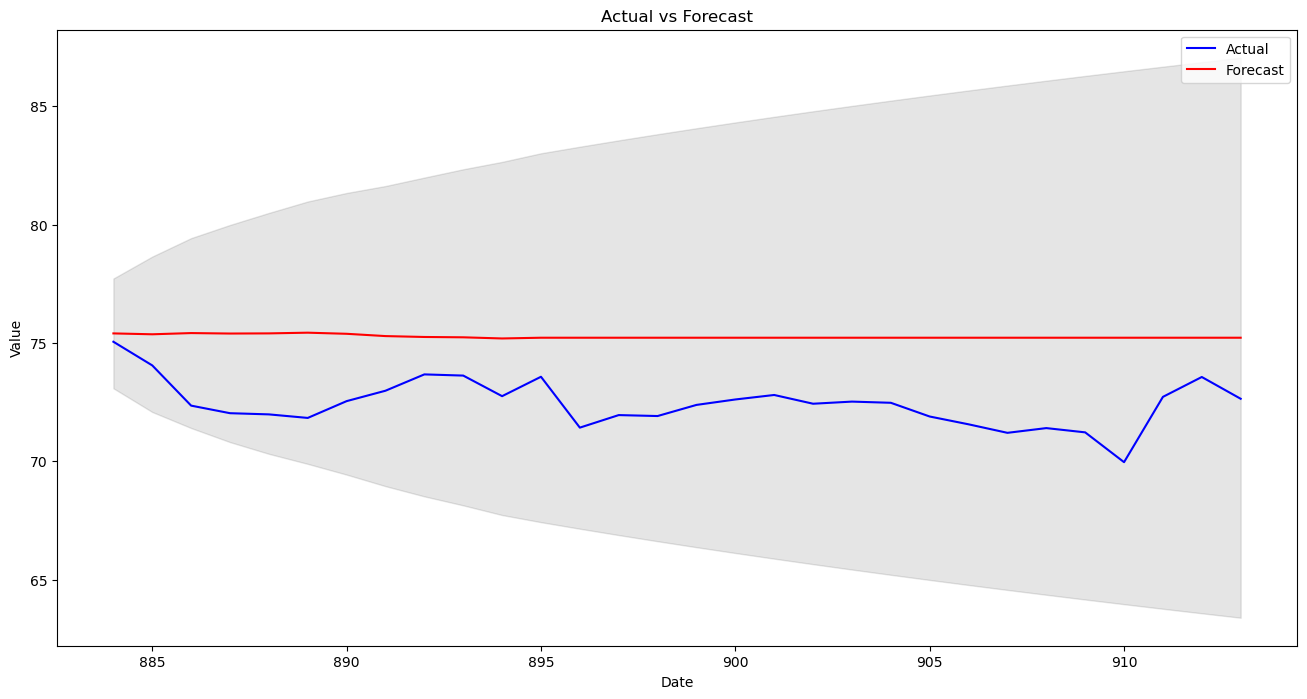

In [340]:
#Plotting 30 days into the future, comparing with actual and confidence levels

import matplotlib.pyplot as plt
import pandas as pd

# Define step size
step = 30

# Generate forecast and confidence intervals
forecast = result.get_forecast(steps=step)
fc = forecast.predicted_mean
conf = forecast.conf_int()

# Extract the correct index for the forecast period
forecast_index = test.index[:step]

# Create Series for forecast and confidence intervals with the correct index
fc_series = pd.Series(fc, index=forecast_index)
lower_series = pd.Series(conf.iloc[:, 0], index=forecast_index)
upper_series = pd.Series(conf.iloc[:, 1], index=forecast_index)

# Extract the actual data for the last 30 steps
actual_data = test[:step]

# Plotting Actual vs Forecast
plt.figure(figsize=(16, 8))

# Plot actual values (last 30 values of the test data)
plt.plot(actual_data.index, actual_data, label='Actual', color='blue')

# Plot forecast values
plt.plot(fc_series.index, fc_series, label='Forecast', color='red')

# Plot confidence intervals
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.1)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Forecast')
plt.legend(loc='upper right')
plt.show()


Shows that ARIMA model is not optimal for predicting stock price, but useful to detect trends